In [1]:
import warnings
import os

import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from ami import (
    build_ami_fields,
    make_1D_system,
    sed,
    symbolic_hamiltonian_spinful_simplified,
)
from tqdm.notebook import tqdm

In [2]:
plt.style.use("plot_style.mplstyle")

In [3]:
%matplotlib inline

In [4]:
symbolic_hamiltonian_spinful_simplified(dims=2, self_energy=True)

Matrix([
[h_z + k_c*(k_x**2 + k_y**2) - (I*Gamma_Sc + omega)*gamma_Sc(x, y)*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1) + V(x, y),                                                                                  I*alpha_z*k_x + alpha_z*k_y + h_x - I*h_y,              gamma_Sc(x, y)*Delta(x, y)*(I*sin(phi(x, y)) + cos(phi(x, y)))*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1),                                                                                                                          0],
[                                                                               -I*alpha_z*k_x + alpha_z*k_y + h_x + I*h_y, -h_z + k_c*(k_x**2 + k_y**2) - (I*Gamma_Sc + omega)*gamma_Sc(x, y)*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1) + V(x, y),                                                                                                                         0,               gamma_Sc(x, y)*Delta(x, y)*(I*sin(phi(x, y)) + cos(phi(x, y)))*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1)],

In [5]:
fields_params = dict(
    N = 12, 
    L_S = 750, L_N=250,
    mu_S = 10, mu_N = 10, 
    Delta_0 = 1, Delta_phi = np.pi/6,
    gamma_0 = 1, l_smth = 0.02,
    L_B= 6, V_B = 4, mu_ld = 20
)

V, gamma, Delta, phi = build_ami_fields(
    **fields_params
    )

In [6]:
dir_name = f'./output/LS_{fields_params["L_S"]:d}_LN_{fields_params["L_N"]:d}_muS_{fields_params["mu_S"]:d}_muN_{fields_params["mu_N"]:d}_Delta_{fields_params["Delta_0"]:d}_N_{fields_params["N"]}/'
os.makedirs(dir_name, exist_ok=True)

In [7]:
extra = 5
L = fields_params["N"]*(fields_params["L_S"] + fields_params["L_N"]) + fields_params["L_N"] + fields_params["L_B"] + extra
x = np.linspace(-extra -  fields_params["L_B"], L, 1000)

/home/andmai/workspace/andreev_multi_interferometer/ami.py:246: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x / l_smth))


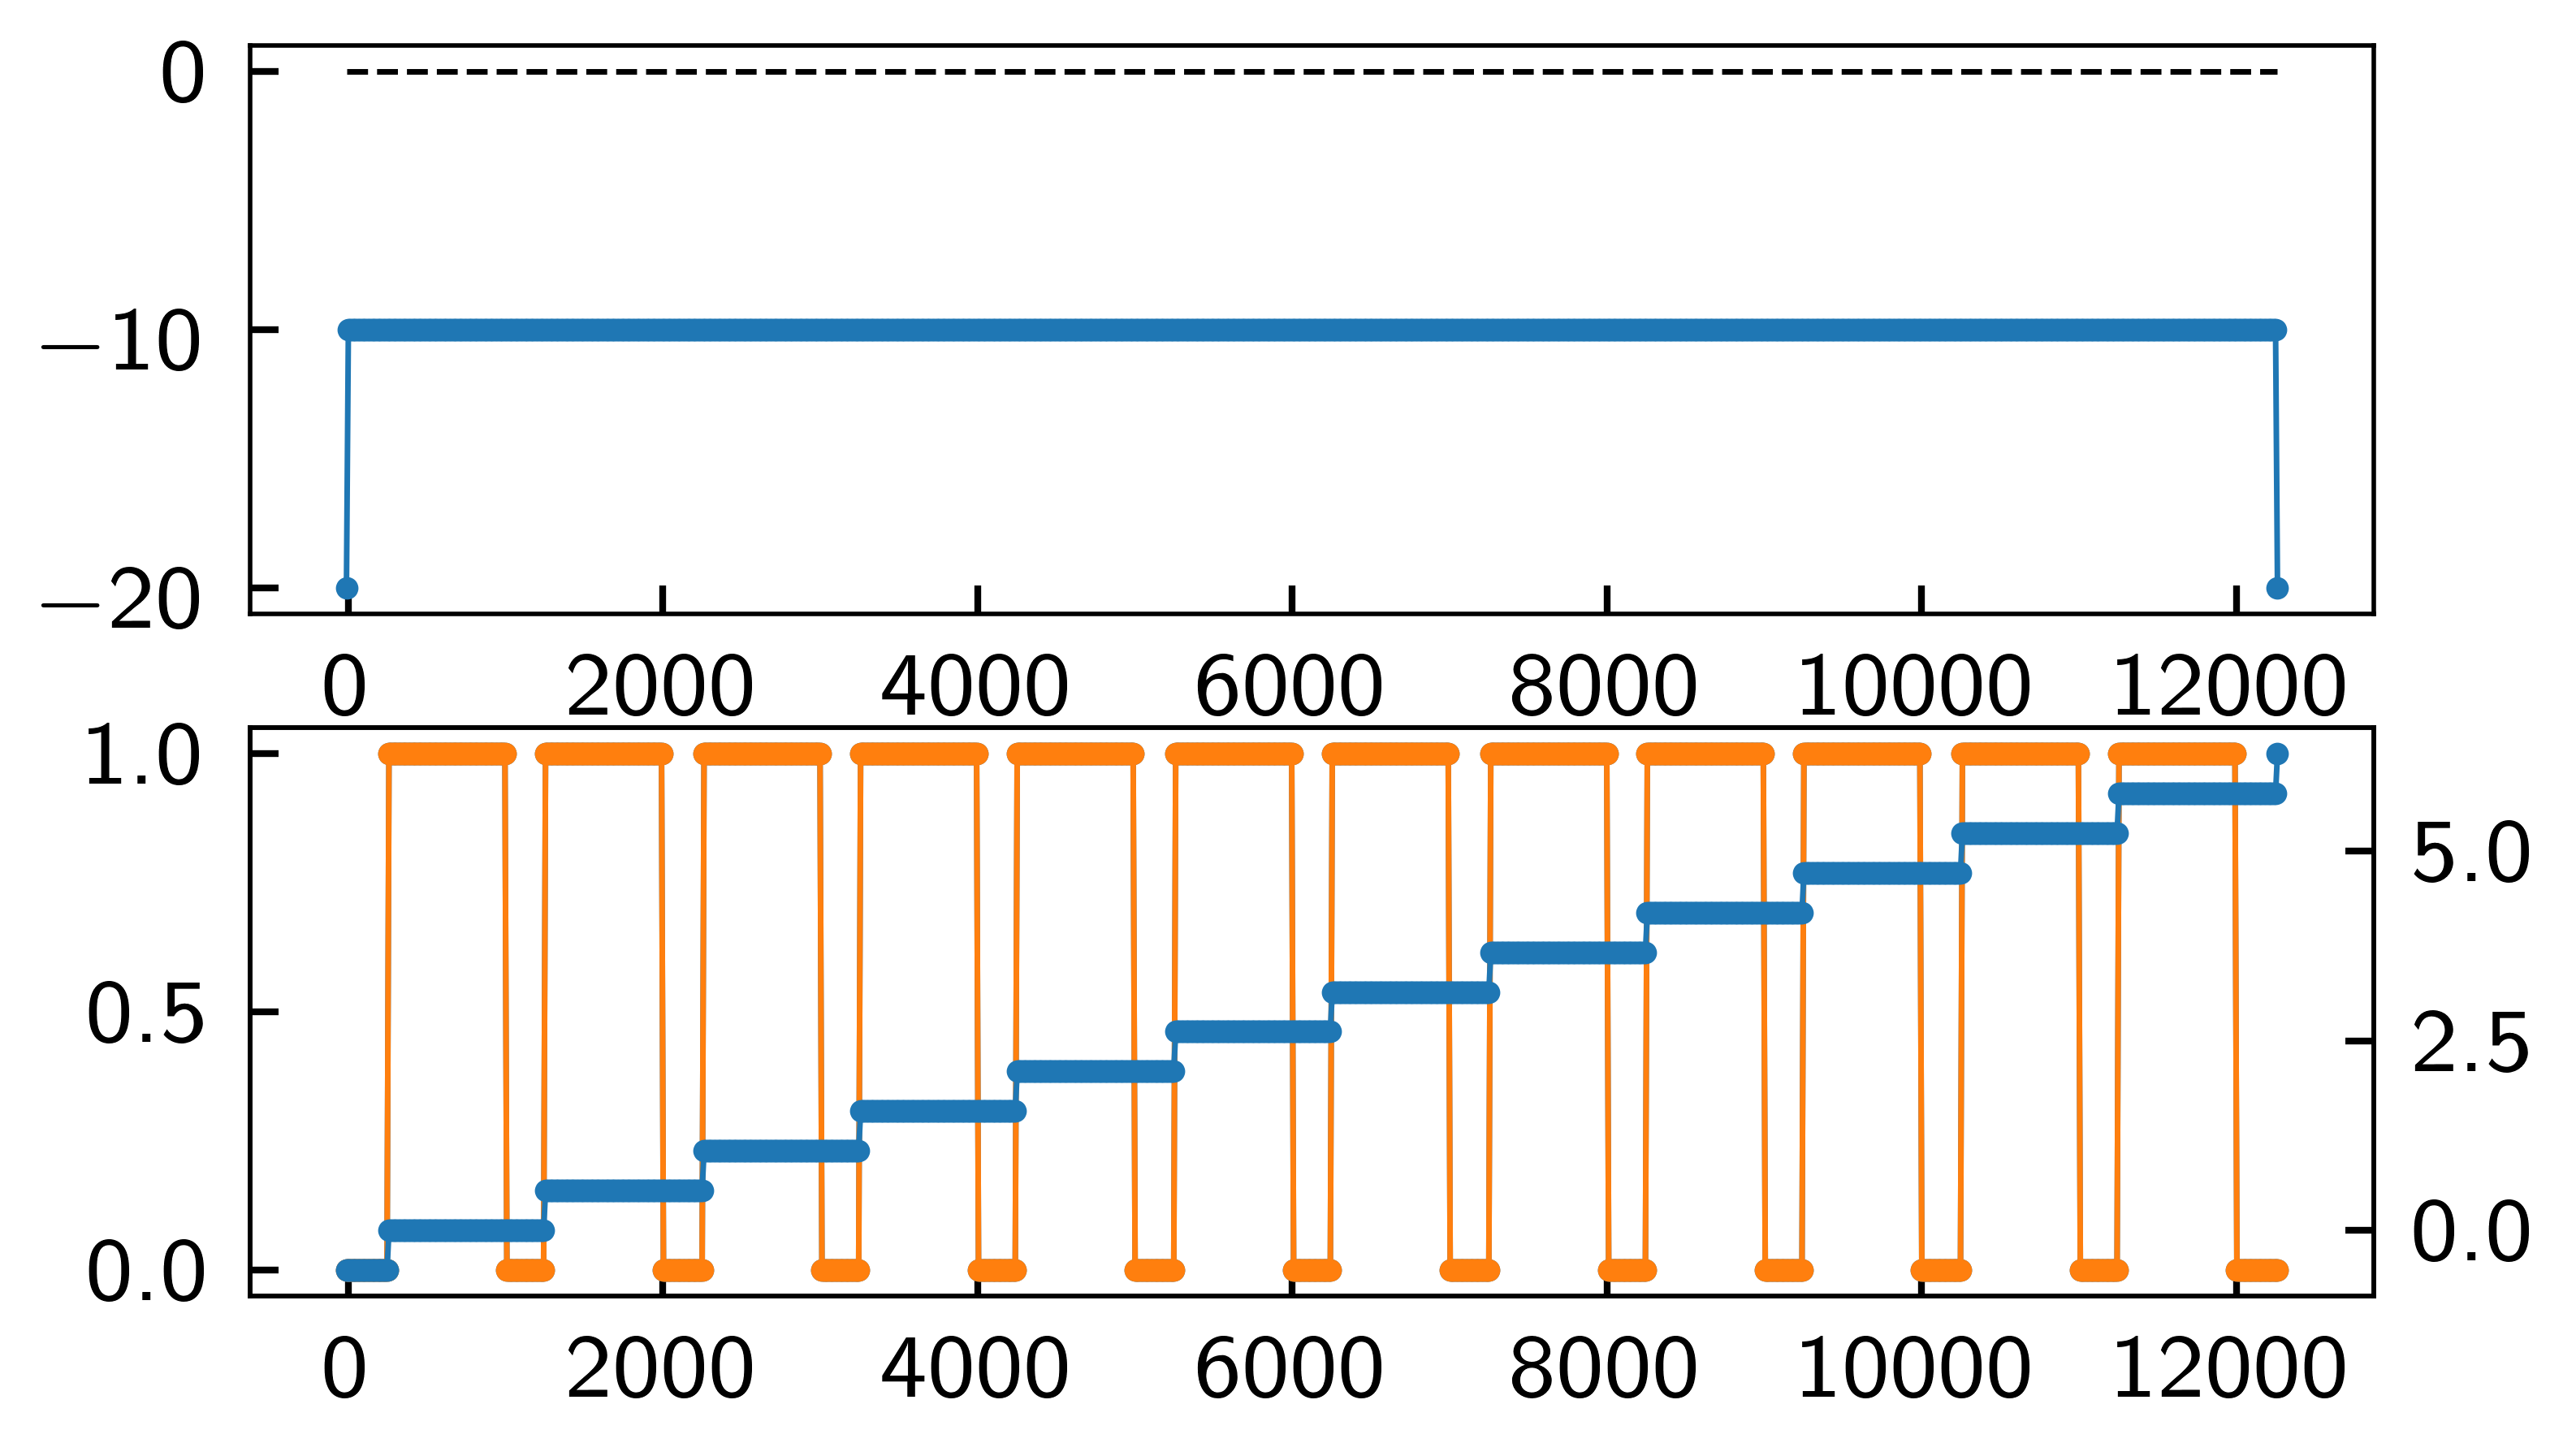

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(x, V(x, 0))
ax1.plot(x, 0*x, '--k')
#ax.set_ylim(-20, 20)
ax2.plot(x, Delta(x, 0))
ax2.plot(x, gamma(x, 0))
ax2.twinx().plot(x, phi(x, 0))

In [9]:
def get_default_params():
    """
    Generate the default prameters dict.
    """

    params = {
        # Material params
        "k_c": 38.0998212 / 0.026,
        "alpha_z":  0,
        # Electrostatics
        "V": lambda *args: 0.0,
        "V_L": lambda *args: 0.0,
        "V_R": lambda *args: 0.0,
        # Induced terms params
        "sed": sed,
        "Gamma_Sc": 1 * 1e-12,
        "gamma_Sc": lambda *args: 0.0,
        "omega": 0.0,
        # Magnetic field
        "h_x": 0.0,
        "h_y": 0.0,
        "h_z": 0.0,
        # Leads params
        "gamma_Sc_lead": lambda *args: 0.0,
        "alpha_z_lead": 0.0,
        "h_x_lead": 0.0,
        "h_y_lead": 0.0,
        "h_z_lead": 0.0,
        # Functions
        "cos" : np.cos,
        "sin" : np.sin,
        "Delta" : Delta,
        
    }

    return params

In [10]:
params = get_default_params()

# Spectrum

In [11]:
a_x = 10
bounds = np.array([x.min(), x.max()])

In [12]:
phi_N = 101
phi_ax = np.linspace(0, 4*np.pi, phi_N)

e_N = 101
e_ax = np.linspace(-1.05, 1.05, e_N) * fields_params["Delta_0"]

In [ ]:
ws = []

T = np.zeros((phi_N, e_N, 2, 2, 2, 2))
N = np.zeros((phi_N, e_N, 2, 2, 2, 2))

systf = make_1D_system(a_x, bounds, with_leads=True, finalized=True, spinless_smatrix=True, self_energy=True)

for i, dphi in tqdm(enumerate(phi_ax), total=phi_N):
    for j, e in enumerate(e_ax):
        
        fields_params.update(Delta_phi = dphi)
        V, gamma_Sc, Delta, phi = build_ami_fields(
        **fields_params
        )

        params.update(V=V, 
                      V_L = lambda x, y : V(bounds[0], y),
                      V_R = lambda x, y : V(bounds[1], y), 
                      Delta = Delta, 
                      gamma_Sc=gamma_Sc,
                      phi=phi,
                      omega=e,
                     )

   
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            smatrix = kwant.smatrix(
                systf, energy=params["omega"], params=params, check_hermiticity=False
            )
      
        for lead_in_idx, lead_out_idx, cq_in_idx, cq_out_idx in np.ndindex(
            2, 2, 2, 2
        ):

            T[
                i, j, lead_out_idx, lead_in_idx, cq_out_idx, cq_in_idx
            ] = smatrix.transmission(
                lead_out=(lead_out_idx, cq_out_idx),
                lead_in=(lead_in_idx, cq_in_idx),
            )

            N[i, j, lead_out_idx, lead_in_idx, cq_out_idx, cq_in_idx] = len(
                smatrix.submatrix(
                    lead_out=(lead_out_idx, cq_out_idx),
                    lead_in=(lead_in_idx, cq_in_idx),
                )
            )

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
np.save(dir_name + "T.npy", T)
np.save(dir_name + "phi_ax.npy", phi_ax)
np.save(dir_name + "e_ax.npy", e_ax)

In [ ]:
plt.plot(phi_ax, T[:, e_N//2,  0, 0, 0, 0], label="Ree")
plt.plot(phi_ax, T[:, e_N//2,  0, 0, 1, 0], label="Rhe")
plt.plot(phi_ax, T[:, e_N//2,  1, 0, 0, 0], label="Tee")
plt.plot(phi_ax, T[:, e_N//2,  1, 0, 1, 0], label="The")
plt.legend()

In [ ]:
phi_idx=0

plt.plot(e_ax, T[phi_idx, :,  0, 0, 0, 0], label="Ree")
plt.plot(e_ax, T[phi_idx, :,  0, 0, 1, 0], label="Rhe")
plt.plot(e_ax, T[phi_idx, :,  1, 0, 0, 0], label="Tee")
plt.plot(e_ax, T[phi_idx, :,  1, 0, 1, 0], label="The")
plt.legend()

In [ ]:
phi_idx=phi_N//2

plt.plot(e_ax, T[phi_idx, :,  0, 0, 0, 0], label="Ree")
plt.plot(e_ax, T[phi_idx, :,  0, 0, 1, 0], label="Rhe")
plt.plot(e_ax, T[phi_idx, :,  1, 0, 0, 0], label="Tee")
plt.plot(e_ax, T[phi_idx, :,  1, 0, 1, 0], label="The")
plt.legend()

In [ ]:
def add_tl_label(ax, text):
    ax.text(
        0.02,
        0.98,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(facecolor=[1, 1, 1, 0.90], edgecolor="none", pad=0.25),
    )

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

im = axs[0, 0].contourf(phi_ax, e_ax, T[:, :,  0, 0, 0, 0].T, levels=np.linspace(0, 2, 101), cmap="inferno")
axs[0, 1].contourf(phi_ax, e_ax, T[:, :,  0, 0, 1, 0].T, levels=np.linspace(0, 2, 101), cmap="inferno")
axs[1, 0].contourf(phi_ax, e_ax, T[:, :,  1, 0, 0, 0].T, levels=np.linspace(0, 2, 101), cmap="inferno")
axs[1, 1].contourf(phi_ax, e_ax, T[:, :,  1, 0, 1, 0].T, levels=np.linspace(0, 2, 101), cmap="inferno")

axs[1, 0].set_xlabel(r"$\delta \phi$")
axs[1, 1].set_xlabel(r"$\delta \phi$")

axs[0, 0].set_ylabel(r"$\omega$")
axs[1, 0].set_ylabel(r"$\omega$")

add_tl_label(axs[0, 0], r"$R^{ee}$")
add_tl_label(axs[0, 1], r"$R^{he}$")
add_tl_label(axs[1, 0], r"$T^{ee}$")
add_tl_label(axs[1, 1], r"$T^{he}$")

axs[1, 0].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
axs[1, 1].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])

plt.colorbar(im, ax = axs)
fig.savefig(dir_name+"coefficients.png")

In [ ]:
G_11 = 2 - T[:, :,  0, 0, 0, 0] + T[:, :,  0, 0, 1, 0] 
G_12 = - T[:, :,  1, 0, 0, 0] + T[:, :,  1, 0, 1, 0]

G_22 = 2 - T[:, :,  1, 1, 0, 0] + T[:, :,  1, 1, 1, 0] 
G_21 = - T[:, :,  0, 1, 0, 0] + T[:, :,  0, 1, 1, 0]

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

im1 = axs[0, 0].contourf(phi_ax, e_ax, G_11.T, levels=np.linspace(-4, 4, 100), cmap="RdBu")
im2 = axs[0, 1].contourf(phi_ax, e_ax, G_12.T, levels=np.linspace(-4, 4, 101), cmap="RdBu")
im3 = axs[1, 0].contourf(phi_ax, e_ax, G_21.T, levels=np.linspace(-4, 4, 101), cmap="RdBu")
im4 = axs[1, 1].contourf(phi_ax, e_ax, G_22.T, levels=np.linspace(-4, 4, 101), cmap="RdBu")

axs[1, 0].set_xlabel(r"$\delta \phi$")
axs[1, 1].set_xlabel(r"$\delta \phi$")

axs[0, 0].set_ylabel(r"$\omega$")
axs[1, 0].set_ylabel(r"$\omega$")

add_tl_label(axs[0, 0], r"$G_{11}$")
add_tl_label(axs[0, 1], r"$G_{12}$")
add_tl_label(axs[1, 0], r"$G_{21}$")
add_tl_label(axs[1, 1], r"$G_{22}$")


axs[1, 0].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
axs[1, 1].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi], [r"$0$", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])

plt.colorbar(im1, ax = axs)
fig.savefig(dir_name+"conductance.png")

In [ ]:
fields_params

In [ ]:
import types 
import inspect

dp_saved = get_default_params()

for key in dp_saved.keys():
    if isinstance(dp_saved[key], types.FunctionType):
        dp_saved[key] = inspect.getsource(dp_saved[key])

In [ ]:
dp_saved